<h1><font color='Grey'>Plano de Análise</font></h1>
<h4><font color='Grey'>Previsão de preço de passagens</font></h4>

Alcides Gabriel (alcidesgabriel.ds@gmail.com), outubro de 2022

Objetivo: Desenvolver o melhor modelo de previsão do preço das passagens aéreas para essa base de dados. 

<h4><font color='Grey'>Previsão com dados</font></h4>

1. <font color='blue'> Qual modelo melhor se adapta para a previsão dos dados?</font>
  
  - Previsão com diversos modelos para encontrar o mais adequado.
  - Utilização da validação cruzada para evitar dados com viés.
  - Análise com mais de uma medida de erro.

2. <font color='blue'> Qual o melhor desempenho possível com o modelo selecionado?</font>

  - Utilização de Hiperparâmetro para buscar o melhor desempenho do modelo.
  - Confirmação do funcionamento desse modelo com os parâmetros selecionados rodando uma validação cruzada.
  - Visualização Gráfica de cada rodagem para analisar a distribuição do erro.



# Importação

- Importação das bibliotecas 
- Importação do dataset

In [33]:
# Download da biblioteca para o bayesian optimization
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
# Stardard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import FontProperties
import seaborn as sns
import time
import random

# Machine Learning Algorithms
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

# Validation and others
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from skopt import gp_minimize


In [35]:
# Importação do dataset Tratado
dt = pd.read_csv('.../dados_tratados.csv')

# Modelos de Machine Learning


## Função

In [4]:
def tratamento(df):
  """
  Utilizar o LabelEncoder para transformar os dados categóricos em Numéricos.
  """
  df_n = df.copy() # Cria uma cópia
  for i in df_n.select_dtypes(include='object'):
    df_n.loc[:,i] = LabelEncoder().fit_transform(df_n[i]) # Transforma cada categórico em numérico.
  return df_n # Retorna o dado tratado.

def scorer(y_true, y_pred):
  """ 
  Função erro que junto ao make_scorer vai permitir retornar diversos erros 
  de cada modelo para a análise
  """
  r2_l.append(r2_score(y_true, y_pred)) # Envia o erro R2 para uma lista  
  mae.append(mean_absolute_error(y_true, y_pred)) # Envia o erro MAE para uma lista  
  rmse.append(mean_squared_error(y_true, y_pred)**(1/2)) # Envia o erro RMSE para uma lista  
  print('----- Rodada Concluida ------')
  return r2_score(y_true, y_pred)

In [ ]:
def run():
  """
  Função principal de análise.
  Contém as listas dos erros e outras informações a serem salvas
  Contém a função da validação cruzada
  Contém as funções de cada modelo testado.
  """

  # Lista de Erros, Modelos, Índices e Tempo.
  rmse = []
  mae = []
  r2_l = []
  mod = []
  ind = [] 
  tempo = []


  def validacao_cruzada(modelo, dataset, mode):
    print(f'\nModelo sendo rodado: {mode}') # Mostra qual modelo está em análise.
    st = time.time() # Salva o tempo do início da função

    # Separação do dataset
    X = dataset.drop('price',axis=1) 
    y = dataset['price']

    # Validação Cruzada
    cv = KFold(n_splits=5) # Separa o dataset em 5 partes.
    resultado = np.mean(cross_val_score(estimator=modelo, X=X, y=y, scoring=make_scorer(scorer), cv = cv)) # Função da validação cruzada

    # Salvar Índice, Modelo e Tempo.
    lii = [mode]*5
    mod.extend(lii)
    inde = [i+1 for i in range(5)]
    ind.extend(inde)
    et = time.time()
    tempo.append([round(et-st), mode])

    print(f'Tempo de rodagem: {round(et-st)} segundos')



  
  def lg(df):

    df_modelo = tratamento(df) # Aplica na transformação dos dados
    modelo = LGBMRegressor() # Modelo Utilizado
    return validacao_cruzada(modelo, df_modelo,'Light') # Aplica na validação cruzada

  def xg(df):
    df_modelo = tratamento(df)
    modelo = XGBRegressor(objective='reg:squarederror')
    return validacao_cruzada(modelo, df_modelo,'XGB')

  def ada(df):
    df_modelo = tratamento(df)
    modelo = AdaBoostRegressor(n_estimators=200)
    return validacao_cruzada(modelo, df_modelo,'Ada')
    
  def gb(df):
    df_modelo = tratamento(df)
    modelo = GradientBoostingRegressor(n_estimators=200)
    return validacao_cruzada(modelo, df_modelo,'GB')

  def rf(df):
    df_modelo = tratamento(df)
    modelo = RandomForestRegressor()
    return validacao_cruzada(modelo, df_modelo,'RF')

  def voto(df):
    df_modelo = tratamento(df) 
    modelos = [('lg', LGBMRegressor()),('ada', AdaBoostRegressor()),('gb',GradientBoostingRegressor()),('xg',XGBRegressor(objective='reg:squarederror'))]
    modelo = VotingRegressor(estimators=modelos)
    return validacao_cruzada(modelo, df_modelo,'Voto')
  
  # Aplicação das Funções
  lg(dt)
  xg(dt)
  gb(dt)
  ada(dt)
  rf(dt)
  voto(dt)

  return  rmse, mae, r2_l, mod, ind, tempo


In [ ]:
def relatorio(L1, L2, L3, L4, indice):
  """
 Função gráfica que irá retornar uma imagem contendo o desempenho dos modelos testados

  """
  # Criação do Dataset
  df = pd.DataFrame({
      'Modelo':L4,
      'R2':L1,
      'RMSE':L2,
      'MAE':L3,
      'Ind':indice
  })
  elementos = df.Modelo.nunique() # Separação da quantidade de elementos.

# ============ Conf ============
  figura = plt.figure(figsize=(20,8)) # Criação da Figura
  tamanho = (1,3) # Tamanho dos subplots
  figura.suptitle('Relatório do erro de cada modelo testado', fontsize=30, color='dimgrey') # Título
  cont = 0 # Contador.
  plt.subplots_adjust(left=0.1, # Ajustes da imagem
                    bottom=0.1,
                    right=0.9,
                    top=0.8,
                    wspace=0.6,
                    hspace=0.4) 
# ============ plotagem (RMSE e MAE) ============
  # Plotagem dos 2 primeiros gráficos.
  for elem in ['RMSE','MAE']: 

    # --- Função Cor ------
    ine =  df[elem].idxmin() # Descobre qual índice contém o menor valor de estudado
    destaque = df.loc[ine,'Modelo'] # Seleciona o modelo do índice 
    cor = []
    marcas = []
    for j in df['Modelo'].unique(): # Função criada para salvar a cor
      if j == destaque:
        cor.append('teal')
        marcas.append('o') # Salvar um marcador
      else:
        marcas.append('>')
        cor.append('lightgrey')

    # --- Localização e Plot ------

    pos = (0,cont) # Localização na imagem
    ax = plt.subplot2grid(tamanho, pos) # Axis
    linha = sns.lineplot(data=df,
                x = 'Ind',
                y = elem,
                hue = 'Modelo', palette=cor,style='Modelo', markers=marcas, dashes=True) # Plot


    plt.title(elem, color='dimgrey', horizontalalignment='left', x=0, fontsize=20, verticalalignment='bottom') # Título da imagem

    # --- Configurações de axis ----
    limS = df[elem].max()*1.10 # Limite máximo de Y
    limI = df[elem].min()*.9 # Limite mínimo de Y
    linha.set_ylim([round(limI),round(limS)]) # Definição dos limites
    linha.set(xlabel='', ylabel='') # Remover titulos de x e y 
    linha.set_xlim([0,elementos+1]) # Definir limites de X
    linha.legend().remove() # remover legenda
    
      # Desativar Visualização 
    linha.spines['top'].set_visible(False)
    linha.spines['right'].set_visible(False)

      # Definir Cores
    linha.spines['left'].set_color('darkgrey')
    linha.spines['bottom'].set_color('darkgrey')
    linha.tick_params(axis='both', colors='darkgrey')

      # Definição das posições dos textos no gráfico.
    if elem == 'RMSE':
      loc3 = [0,0,-2,0,0,0]
      loc4 = [1,1,-1,-1,1,1]
    else:
      loc3 = [0,0.5,-0.5,0,0,0]
      loc4 = [1,-1,-1,1,1,1]
    cop = 0
    for k, cores in zip(df['Modelo'].unique(), cor):
        # Configurações de texto.
      if cores != 'teal': 
        cores = 'black'
      locc = loc3[cop]
      locc1 = loc4[cop]
      cop += 1
      valor = df.loc[df['Modelo'] == k, elem].tolist()[-1]
        # Plotagem do texto. (Modelo utilizado)
      linha.annotate(k, xy = (elementos +0.8, valor+(80*locc)), verticalalignment='center',horizontalalignment='center', color=cores, fontsize=12)
      if cores == 'black':
        cores = 'dimgrey'
      else:
        cores = 'black'
      for loc in range(5):
        # Plotagem do texto. (Resultado de cada rodada do modelo)
        valor = df.loc[df['Modelo'] == k, elem].iloc[loc]
        linha.annotate(round(valor), xy = (loc+1, valor+(100*locc1)), verticalalignment='center',horizontalalignment='center',fontsize=10, color=cores)
    cont += 1

# ============ plotagem (R2) ============
  # --- Função Cor ------
  ine =  df['R2'].idxmax() # Descobre qual índice contém o maior valor de estudado
  destaque = df.loc[ine,'Modelo'] # Seleciona o modelo do índice 
  cor = []
  marcas = []
  for j in df['Modelo'].unique(): # Função criada para salvar a cor
    if j == destaque:
      cor.append('teal')
      marcas.append('o')
    else:
      marcas.append('>')
      cor.append('lightgrey')
  pos = (0,2)
  ax = plt.subplot2grid(tamanho, pos) # Axis

  linha = sns.lineplot(data=df,
              x = 'Ind',
              y = 'R2',
              hue = 'Modelo', palette=cor,style='Modelo', markers=marcas, dashes=True) #Plot
  

  plt.title('R2', color='dimgrey', horizontalalignment='left', x=0, fontsize=20, verticalalignment='bottom') #Título

    # Definição de Limites
  limS = df['R2'].max()*1.01
  limI = df['R2'].min()*.98
  linha.set_ylim([limI,limS])
  linha.set(xlabel='', ylabel='')
  linha.set_xlim([0,elementos+1])
  linha.legend().remove()

    # Remover spines
  linha.spines['top'].set_visible(False)
  linha.spines['right'].set_visible(False)

    # Alterar Cores
  linha.spines['left'].set_color('darkgrey')
  linha.spines['bottom'].set_color('darkgrey')
  linha.tick_params(axis='both', colors='darkgrey')


  loc3 = [1,-1,1,1,1,-1]
  cop = 0
  for k, cores in zip(df['Modelo'].unique(), cor):
    if cores != 'teal':
      cores = 'black'
    locc = loc3[cop]
    cop += 1
    valor = df.loc[df['Modelo'] == k, 'R2'].tolist()[-1]
      # Texto na imagem (Modelo)
    linha.annotate(k, xy = (elementos+0.8, valor+(0.001*locc)),horizontalalignment='center' ,verticalalignment='center', color=cores, fontsize=12)
    if cores == 'black':
        cores = 'dimgrey'
    else:
        cores = 'black'
    for loc in range(5):
      # Texto na imagem (Resultado individual)
      valor = df.loc[df['Modelo'] == k, 'R2'].iloc[loc]
      linha.annotate(round(valor,4), xy = (loc+1, valor+(0.002*(locc))), verticalalignment='center',horizontalalignment='center',fontsize=10,color=cores)
    



In [ ]:
def relatorio_2(tp):
  """
  Imagem com o intuito de análisar o tempo de execução de cada modelo.
  """
  temporario = pd.DataFrame(tp, columns=['Tempo','Modelo'])
# ========== Configurações ===============
  tamanho = (1,3) 
  figura = plt.figure(figsize=(20,6))
  figura.suptitle('Análise de Resultados', fontsize=30, color='dimgrey', y=1.1, horizontalalignment='center')
  cont = 0
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.6,
                    top=0.85,
                    wspace=0.6)

# ========== Plotagem ====================
  ine =  temporario['Tempo'].idxmax() # Descobre qual índice contém o maior valor de estudado
  destaque_max = temporario.loc[ine,'Modelo'] # Seleciona o modelo do índice 
  ine =  temporario['Tempo'].idxmin() # Descobre qual índice contém o maior valor de estudado
  destaque_min = temporario.loc[ine,'Modelo'] # Seleciona o modelo do índice 
  cor = []
  for j in temporario['Modelo'].unique(): # Função criada para salvar a cor
    if (j == destaque_max) | (j == destaque_min):
      cor.append('teal')
    else:
      cor.append('lightgrey')

  pos = (0,0)
  ax = plt.subplot2grid(tamanho, pos, colspan=2) # Axis

  barras = sns.barplot(data=temporario,
                      x='Modelo',y='Tempo', palette=cor)
  plt.title('Tempo de execução dos modelos em segundos', horizontalalignment='left',x=0, color='grey',fontsize=15, verticalalignment='bottom') #plot

    # Desativar Spines e tikcs
  barras.spines['top'].set_visible(False)
  barras.spines['right'].set_visible(False)
  barras.spines['left'].set_visible(False)
  barras.tick_params(left=False, labelleft=False)
  barras.set(xlabel='', ylabel='')
    # Mudar Cores
  barras.spines['bottom'].set_color('darkgrey')
  barras.tick_params(axis='both', labelcolor='darkgrey')
  for i in [0,4]:
    plt.gca().get_xticklabels()[i].set_color('teal')
    # Alterar limites
  barras.set_ylim([0,temporario['Tempo'].max()*1.2])

  c = 0
  for i in temporario['Tempo']:
    barras.annotate(i, xy=(c,i), horizontalalignment='center', verticalalignment='bottom')
    c+=1

# ========== Texto ==================== 
  pos = (0,2)
  ax = plt.subplot2grid(tamanho, pos)
  ax.axis('off')
  texto = """     Analisando o relatório anterior é possível chegar a conclusão que
os dois melhores modelos foram: RandomForest e LightGBM. O modelo RandomForest atua com base no
bagging, onde diversas árvores aleatórias chegam a uma conclusão e há uma votação, já o lightgbm
funciona como boosting onde cada árvore criada aprende com o erro da anterior. 
    
    Buscando o resultado o certo seria utilizar somente o randomforest para a previsão, mas ao verificar 
o tempo de execução para uma validação cruzada de 5 etapas, sendo possível ver nesse gráfico ao lado, 
o lightgbm é mais de 40 vezes mais rápido que o RandomForest. Sendo assim é uma escolha interessante 
buscar hiperparâmetro no lightgbm que atuem melhor que o randomforest."""
  plt.annotate(texto, xy=(0,.8), verticalalignment='top',color='dimgrey',fontsize=12)



## Análise

In [ ]:
rmse, mae, r2_l, mod, ind, tempo = run()


Modelo sendo rodado: Light
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
Tempo de rodagem: 15 segundos

Modelo sendo rodado: XGB
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
Tempo de rodagem: 70 segundos

Modelo sendo rodado: GB
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
Tempo de rodagem: 415 segundos

Modelo sendo rodado: Ada
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
Tempo de rodagem: 109 segundos

Modelo sendo rodado: RF
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida ------
----- Rodada Concluida -----

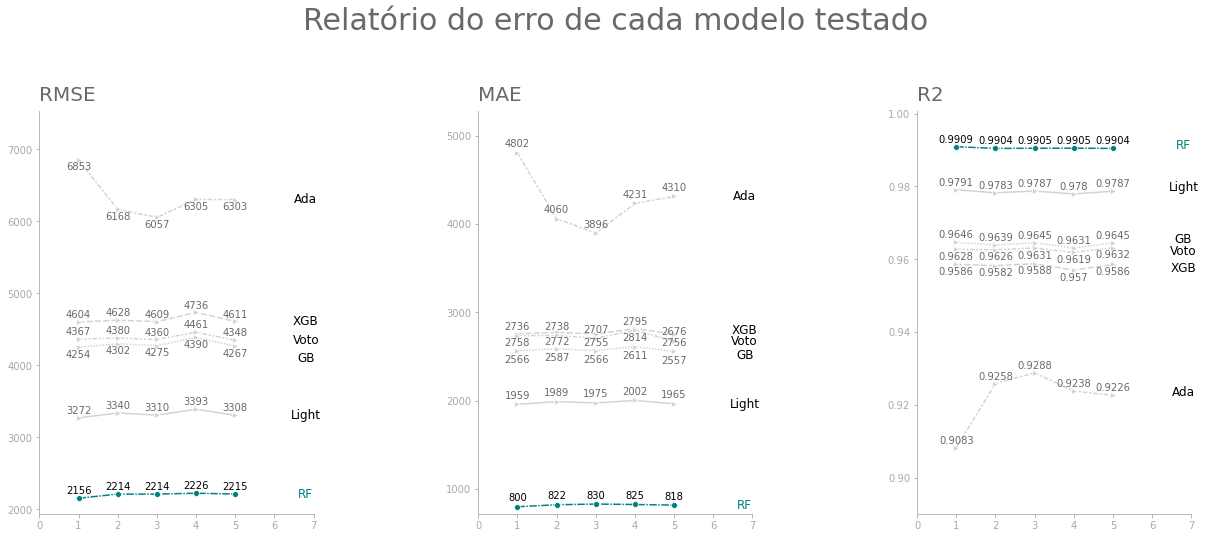

In [ ]:
relatorio(r2_l, rmse, mae, mod, ind)

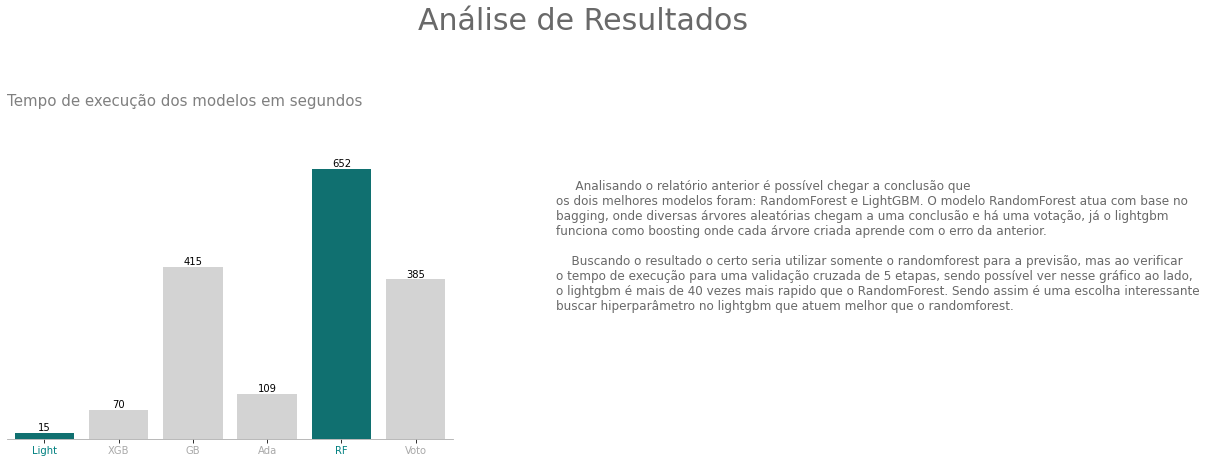

In [ ]:
relatorio_2(tempo)

# Hiperparâmetro


Para encontrar a melhor combinação de parâmetros para o modelo Lightgbm
a sequência será feita da seguinte maneira:

1. Técnica de procura dos parâmetros utilizada é: Bayesian Optimization.
2. Validação Cruzada de 3 partes para a análise.
3. Método de error para avaliação vai ser o R2

## Função

In [50]:
def scorer(y_true, y_pred):
    # Altera que ao invés de salvar os dados em listas, esse salva cada dado individualmente e plota.
    r2_l = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**(1/2)
    print(f'R2 : {round(r2_l*100,2)} \nMAE : {round(mae,2)}, \nRMSE : {round(rmse,2)}' )
    print('----- Rodada Concluida ------')
    return r2_score(y_true, y_pred)

def hiper(params):
  # ------- Separação dos dados
  dataset = tratamento(dt)
  X = dataset.drop('price',axis=1)
  y = dataset['price']
  print(f'Parametros sendo analisados: {params}')
  # ------- parâmetros
  parametros = {
      'learning_rate':params[0],
      'max_depth':params[1],
      'n_estimators':params[2],
      'num_leaves':params[3],
  }

  modelo = LGBMRegressor(**parametros)

  # -------- Validação Cruzada
  cv = KFold(n_splits=3)
  resultado = -np.mean(cross_val_score(estimator=modelo, X=X, y=y, scoring=make_scorer(scorer), cv = cv, n_jobs=-1))
  return resultado

# Criação do espaço de procura

space = [
    (9e-3, 9e-2), #learning_rate
    (180, 200), # max_depth
    (1200, 1500), # n_estimators
    (280, 300) # num_leaves
]


In [40]:
def validacao_cruzada(modelo, dataset, mode):
  # Funciona da mesma maneira que o anterior, alterando somente que não irá passar mais
  # Informações para listas
  print(f'\nModelo sendo rodado: {mode}')
  st = time.time()
  X = dataset.drop('price',axis=1)
  y = dataset['price']
  cv = KFold(n_splits=5)
  resultado = np.mean(cross_val_score(estimator=modelo, X=X, y=y, scoring=make_scorer(scorer), cv = cv))
  et = time.time()
  print(f'Tempo de rodagem: {round(et-st)} segundos')

def lg(df, params):

  df_modelo = tratamento(df)
  modelo = LGBMRegressor(**params)
  return validacao_cruzada(modelo, df_modelo,'Light')



## Análise

In [51]:
resultado = gp_minimize(hiper, space, random_state=1, verbose=True, n_calls=15 , n_random_starts = 5)

Iteration No: 1 started. Evaluating function at random point.
Parametros sendo analisados: [0.08977196968604836, 199, 1238, 300]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 93.9743
Function value obtained: -0.9934
Current minimum: -0.9934
Iteration No: 2 started. Evaluating function at random point.
Parametros sendo analisados: [0.028123207133110062, 188, 1316, 293]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 115.0849
Function value obtained: -0.9924
Current minimum: -0.9934
Iteration No: 3 started. Evaluating function at random point.
Parametros sendo analisados: [0.0847786647352886, 197, 1294, 290]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 95.0677
Function value obtained: -0.9934
Current minimum: -0.9934
Iteration No: 4 started. Evaluating function at random point.
Parametros sendo analisados: [0.0449196843961441, 185, 1360, 298]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 109.7830
Funct

In [55]:
resultado.x

[0.09, 200, 1500, 300]

In [56]:
resultado.fun

-0.9934898282436814

In [58]:
parametros = {
      'learning_rate':resultado.x[0],
      'max_depth':resultado.x[1],
      'n_estimators':resultado.x[2],
      'num_leaves':resultado.x[3],
}

lg(dt, parametros)


Modelo sendo rodado: Light
R2 : 99.44 
MAE : 797.33, 
RMSE : 1685.73
----- Rodada Concluida ------
R2 : 99.41 
MAE : 818.79, 
RMSE : 1743.49
----- Rodada Concluida ------
R2 : 99.43 
MAE : 814.25, 
RMSE : 1720.25
----- Rodada Concluida ------
R2 : 99.4 
MAE : 819.7, 
RMSE : 1763.12
----- Rodada Concluida ------
R2 : 99.41 
MAE : 812.49, 
RMSE : 1743.71
----- Rodada Concluida ------
Tempo de rodagem: 159 segundos


# Conclusão


- Como visto na análise anterior, o modelo após hiperparâmetro melhorou consideravelmente, superando o modelo randomforest com um tempo de execução bem menor, chegando a um resultado de até 99.44 de R2 score.

- Uma boa forma de demonstrar a precisão do modelo é visualizar a distribuição do erro, sendo assim agora será mostrado uma validação cruzada de 5 partes onde será plotado a distribuição do erro do modelo.

## Função


In [125]:
def grafico(y_verd, y_prev):
  """
 Função que irá retornar:
 - Gráfico da diferença entre verdadeiro e previsão
 - Erros (RMSE , R2, MAE)
 - Porcentagem de dados dentro do RMSE.

  """
  # ============= Configurações ============= #
  # Criação e configuração do dataset
  temporario = pd.DataFrame({
      'Verdadeiro':y_verd,
      'Previsão':y_prev
  })
  figura = plt.figure(figsize=(20,8))
  plt.suptitle("Distribuição do erro", fontsize=30, color='dimgrey')
  temporario = temporario.sort_values(by='Verdadeiro', ascending=False).reset_index(drop=True)
  temporario['Diff'] = temporario['Previsão'] - temporario['Verdadeiro']

  # Informações necessárias para plotagem de texto no gráfico.
  rmse = (mean_squared_error(temporario['Verdadeiro'], temporario['Previsão']))**(1/2)
  max_val = temporario['Diff'].max() # Valor Máximo 
  max_loc = temporario['Diff'].idxmax() # Posição do valor máximo
  min_val = temporario['Diff'].min() # Valor mínimo
  min_loc = temporario['Diff'].idxmin() #Posição do valor mínimo

  # Cor dos dados.
  dentro = 0 # Salvar quantos dados estão presentes dentro do RMSE
  cores = []
  for i in temporario['Diff']:
    if (i > rmse) | (i < -rmse):
      cores.append('grey')
    else:
      cores.append('darkred')
      dentro += 1

  
  ax = plt.subplot2grid((1,2),(0,0),colspan=2) # Axis
  box = dict(boxstyle='round',alpha=0.5, color='dimgrey') # Configuração da caixa de texto a ser plotada
  scatter = sns.scatterplot(y=temporario['Diff'],x=temporario.index, c=cores, marker = '+', ax=ax) # Plot

  # Plotagem da caixa de texto contendo informações sobre erro e % 
  texto = f""" R2  : {round(r2_score(y_verd, y_prev)*100,2)} 
 RMSE : {round((mean_squared_error(y_verd, y_prev))**(1/2),0)}
 MAE : {round(mean_absolute_error(y_verd, y_prev),0)}
 Dados dentro do RMSE : {round((dentro / temporario.shape[0])*100,2)} %"""
  scatter.annotate(texto, xy=(temporario.index.max()*0.9, max_val*0.9), bbox=box, color='white', fontsize=14)

  # Plotagem do valor máximo no gráfico (com seta)
  scatter.annotate(f"Valor Máximo \n{max_val:.0f}",
              xy=(max_loc-100, max_val-100), xycoords='data', # Localização da seta
              xytext=(max_loc - 10000, max_val - 350), textcoords='data', # Localização do texto 
              arrowprops=dict(arrowstyle="fancy", connectionstyle="arc3"), # Configuração do estílo de seta/cor/etc
              fontsize=12, horizontalalignment='center', color='firebrick' ) # Configurações do texto.
  
  # Plotagem do valor mínimo no gráfico (com seta)
  scatter.annotate(f"Valor Mínimo \n{min_val:.0f}",
              xy=(min_loc- 100, min_val- 100), xycoords='data',
              xytext=(min_loc - 10000, min_val - 350), textcoords='data',
              arrowprops=dict(arrowstyle="fancy",
                              connectionstyle="arc3"),fontsize=12, horizontalalignment='center', color='teal'
              )
  # Plotagem do RMSE no gráfico (com seta)
  scatter.annotate(f"Dados dentro\n do RMSE",
              xy=(0, 0), xycoords='data',
              xytext=(- 3000, 10000), textcoords='data',
              arrowprops=dict(arrowstyle="fancy",
                              connectionstyle="angle3, angleA=90, angleB=0",color='firebrick'),fontsize=14, horizontalalignment='center', color='black')
  
  scatter.axis('off') # Desativar visualização das axis.
  
  return figura.show()


def scorer(y_verd, y_prev):
  grafico(y_verd, y_prev)
  print('---------')
  return r2_score(y_verd, y_prev)


## Análise



Modelo sendo rodado: Light
---------
---------
---------
---------
---------
Tempo de rodagem: 160 segundos


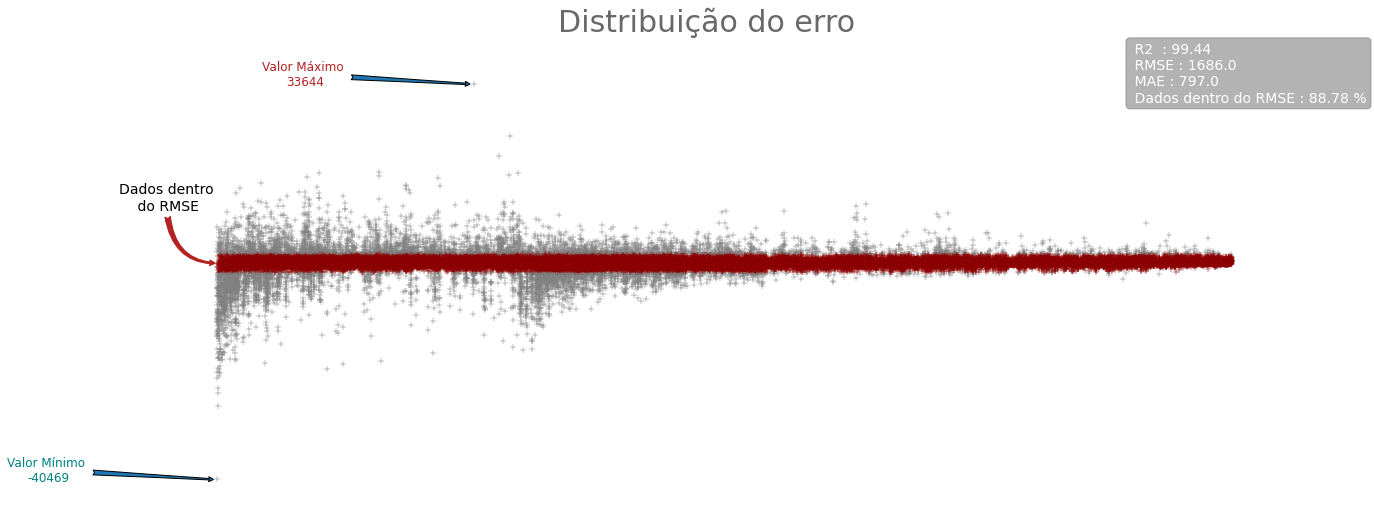

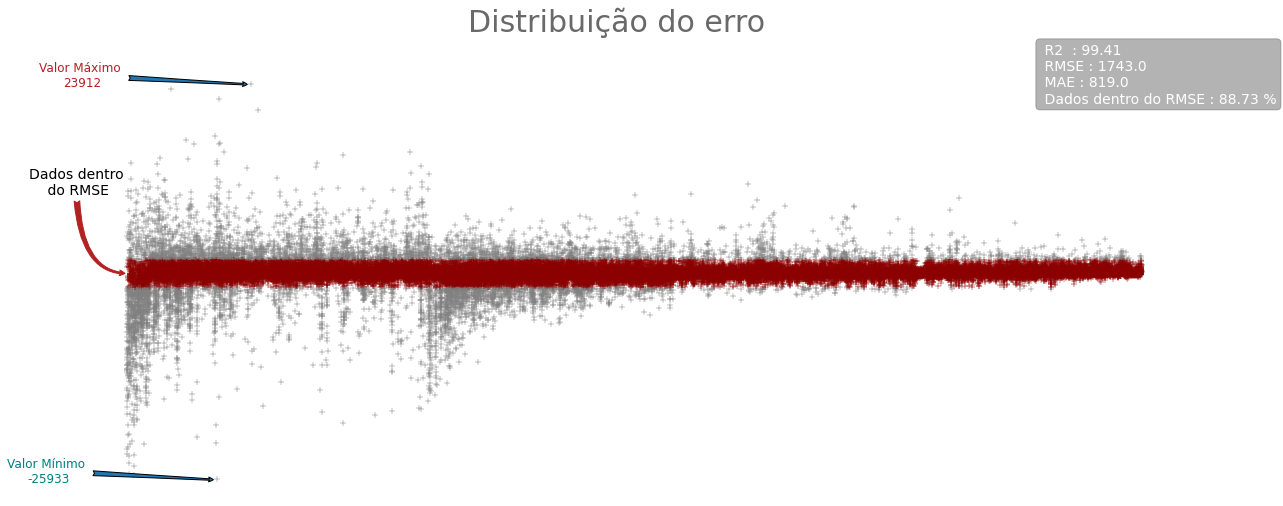

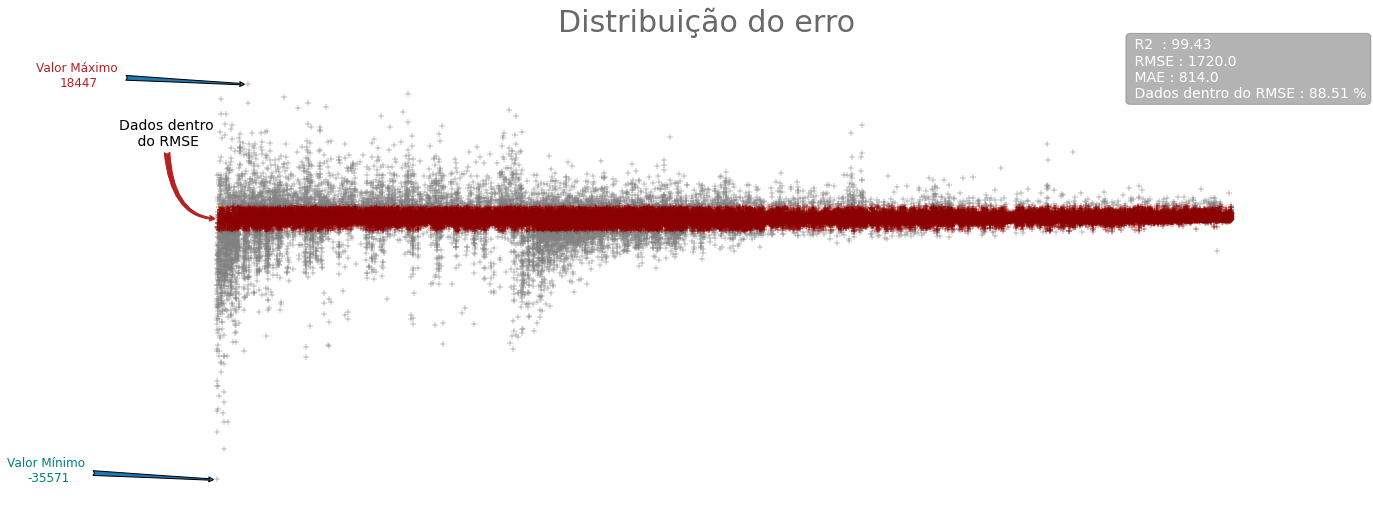

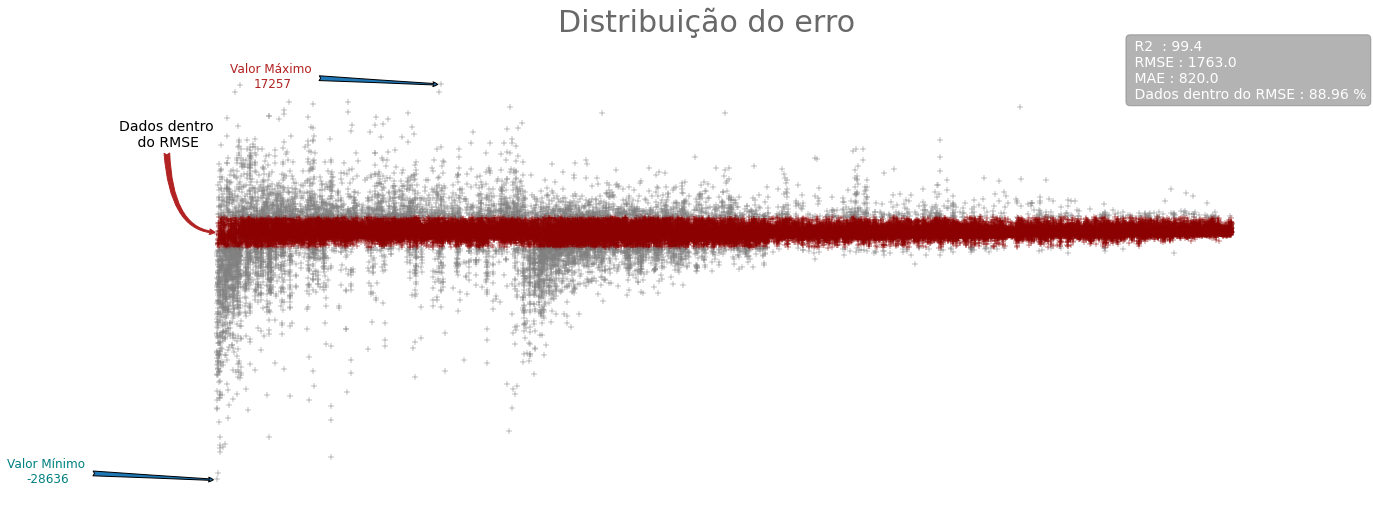

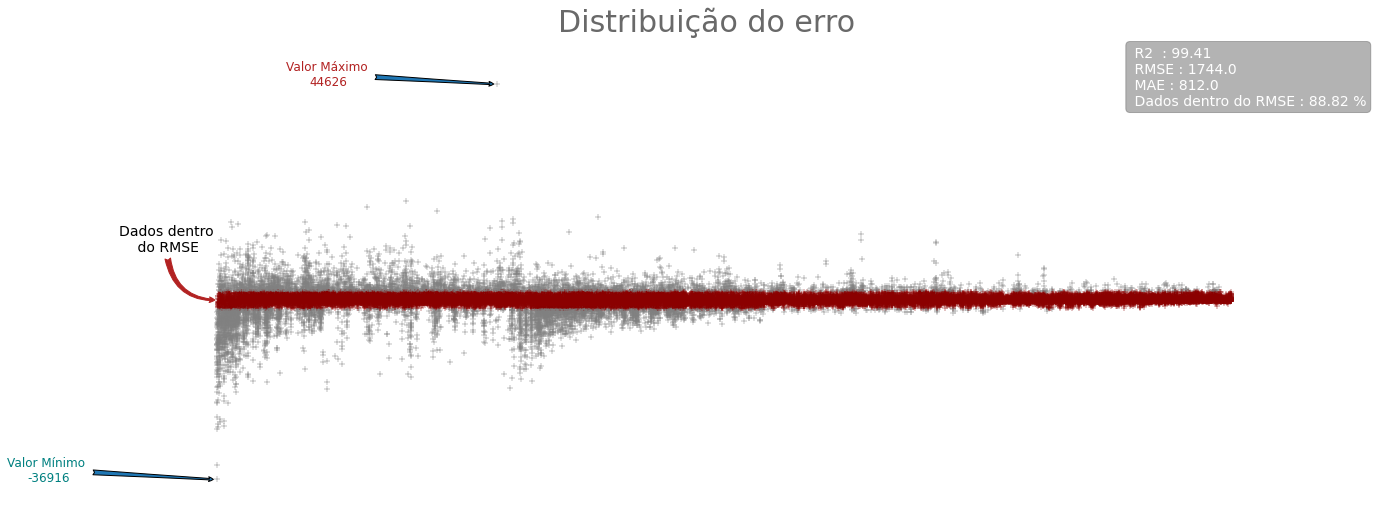

In [126]:
lg(dt, parametros)

<font color='grey'><h1> Conclusão </h1></font>

Usando os dados gráficos é possível chegar as seguintes conclusões:

- O R2 score alcançado é satisfatório.
- O RMSE ainda se mantêm relativamente alto, muito devido aos outliers presentes.
- Mesma situação com o MAE.
- Observando a distribuição dos dados com a informação da porcentagem de dados presentes na faixa do RMSE conclui-se que quanto maior for o valor da passagem mais difícil é encontrar o valor e como foi possível observar que os valores mais altos são para a classe executiva, então essa classe vai apresentar a maior taxa de erro de valor, já a econômica apresentando um valor menor.
- Outras manipulações dos dados poderiam ser feitas em busca de melhores resultados, tais como: normalização do alvo, outras técnicas de encoder como target encoder ou frequency encoder além de feature generation com base nas correlações dos alvos com os dados.
